# Productivity Classification NotebookThis notebook loads data and prepares a productivity classification workflow.

In [37]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [38]:
# ------------------------------
# DATA EXPLORATION: NULL AND OUTLIER PERCENTAGE
# ------------------------------

# ------------------------------
# Step 1: Dataset Overview
# ------------------------------
print("----- Dataset Info -----")
print(df.info())

print("\n----- Dataset Shape -----")
print(df.shape)

print("\n----- Statistical Summary -----")
print(df.describe())

# ------------------------------
# Step 2: Missing Values by Percentage
# ------------------------------
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\n----- Missing Values Summary -----")
print(missing_df.sort_values(by='Percentage', ascending=False))

# ------------------------------
# Step 3: Outlier Detection by Percentage (Numeric Columns Only)
# ------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_summary.append([col, outlier_count, outlier_percent])

outlier_df = pd.DataFrame(outlier_summary, columns=['Column', 'Outlier Count', 'Outlier %'])
print("\n----- Outlier Summary by Percentage -----")
print(outlier_df.sort_values(by='Outlier %', ascending=False))

----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16 

In [39]:
#----------------------------------------
#1 Drop columns with more than 40% missing
#----------------------------------------
missing_threshold = 0.4
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]

print("Dropping columns:", cols_to_drop.tolist())
df = df.drop(columns=cols_to_drop)

# 3. Winsorize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if col not in ['household_id', 'AI_pca1']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

Dropping columns: ['c2_eviarea_avg', 'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg', 'c2_h2021_eviarea', 'c2_h2021_evimax', 'c2_h2021_grn', 'c2_h2021_sen']


In [40]:
# ==============================
# 2. Check columns
# ==============================
print("Before Encoding:")
print(df[['ssa_aez09','landcov']].head())

# ==============================
# 4. One-Hot Encode categorical columns
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=['ssa_aez09', 'landcov'],
    drop_first=True   # avoids multicollinearity (important for regression)
)

# ==============================
# 5. View results
# ==============================
print("\nAfter Encoding:")
print(df_encoded.head())

print("\nNew columns created:")
new_cols = [col for col in df_encoded.columns if 'ssa_aez09_' in col or 'landcov_' in col]
print(new_cols)

# ==============================
# 6. Check dataset shape
# ==============================
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

# change to boolean to numerical value
#bool_cols = df_encoded.select_dtypes(include='bool').columns
#df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df=df_encoded.copy()

Before Encoding:
              ssa_aez09                 landcov
0  Tropic-warm/semiarid  Bare/sparse vegetation
1  Tropic-warm/semiarid  Bare/sparse vegetation
2  Tropic-warm/semiarid  Bare/sparse vegetation
3  Tropic-warm/semiarid  Bare/sparse vegetation
4  Tropic-warm/semiarid  Bare/sparse vegetation

After Encoding:
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.5   
1  20101010100104022        7.7   162.300003    82.900002             0.5   
2  20101010100104033        7.7   162.300003    82.900002             0.5   
3  20101010100104044        7.7   162.300003    82.900002             0.5   
4  20101010100104055        7.7   162.300003    82.900002             0.5   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   

In [42]:
df["road_access"] = pd.cut(
    df["dist_road"],
    bins=[-1, 2, 5, 10, df["dist_road"].max()],
    labels=["Very Good", "Good", "Moderate", "Poor"]
)

In [43]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ------------------------------
# Step 1: Drop irrelevant/correlated columns
# ------------------------------

cols_to_drop = [
    'household_id',
    'dist_market',
    'dist_border',
    'dist_popcenter',
    'dist_admhq','suppress'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 51 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   dist_road                                   4890 non-null   float64 
 1   af_bio_1_x                                  4890 non-null   int64   
 2   af_bio_8_x                                  4890 non-null   int64   
 3   af_bio_12_x                                 4890 non-null   int64   
 4   af_bio_13_x                                 4890 non-null   int64   
 5   af_bio_16_x                                 4890 non-null   int64   
 6   afmnslp_pct                                 4890 non-null   int64   
 7   srtm_1k                                     4890 non-null   int64   
 8   popdensity                                  4890 non-null   int64   
 9   cropshare                                   4890 non-null   int64   
 10  


COMPREHENSIVE CORRELATION AND VIF ANALYSIS

1. PREPARING ALL DATA COLUMNS
----------------------------------------
Total numerical columns in df: 36
Including target column: 'dist_road'

Analyzing 36 columns total:

2. CORRELATION HEATMAP (WITH VALUES)
----------------------------------------


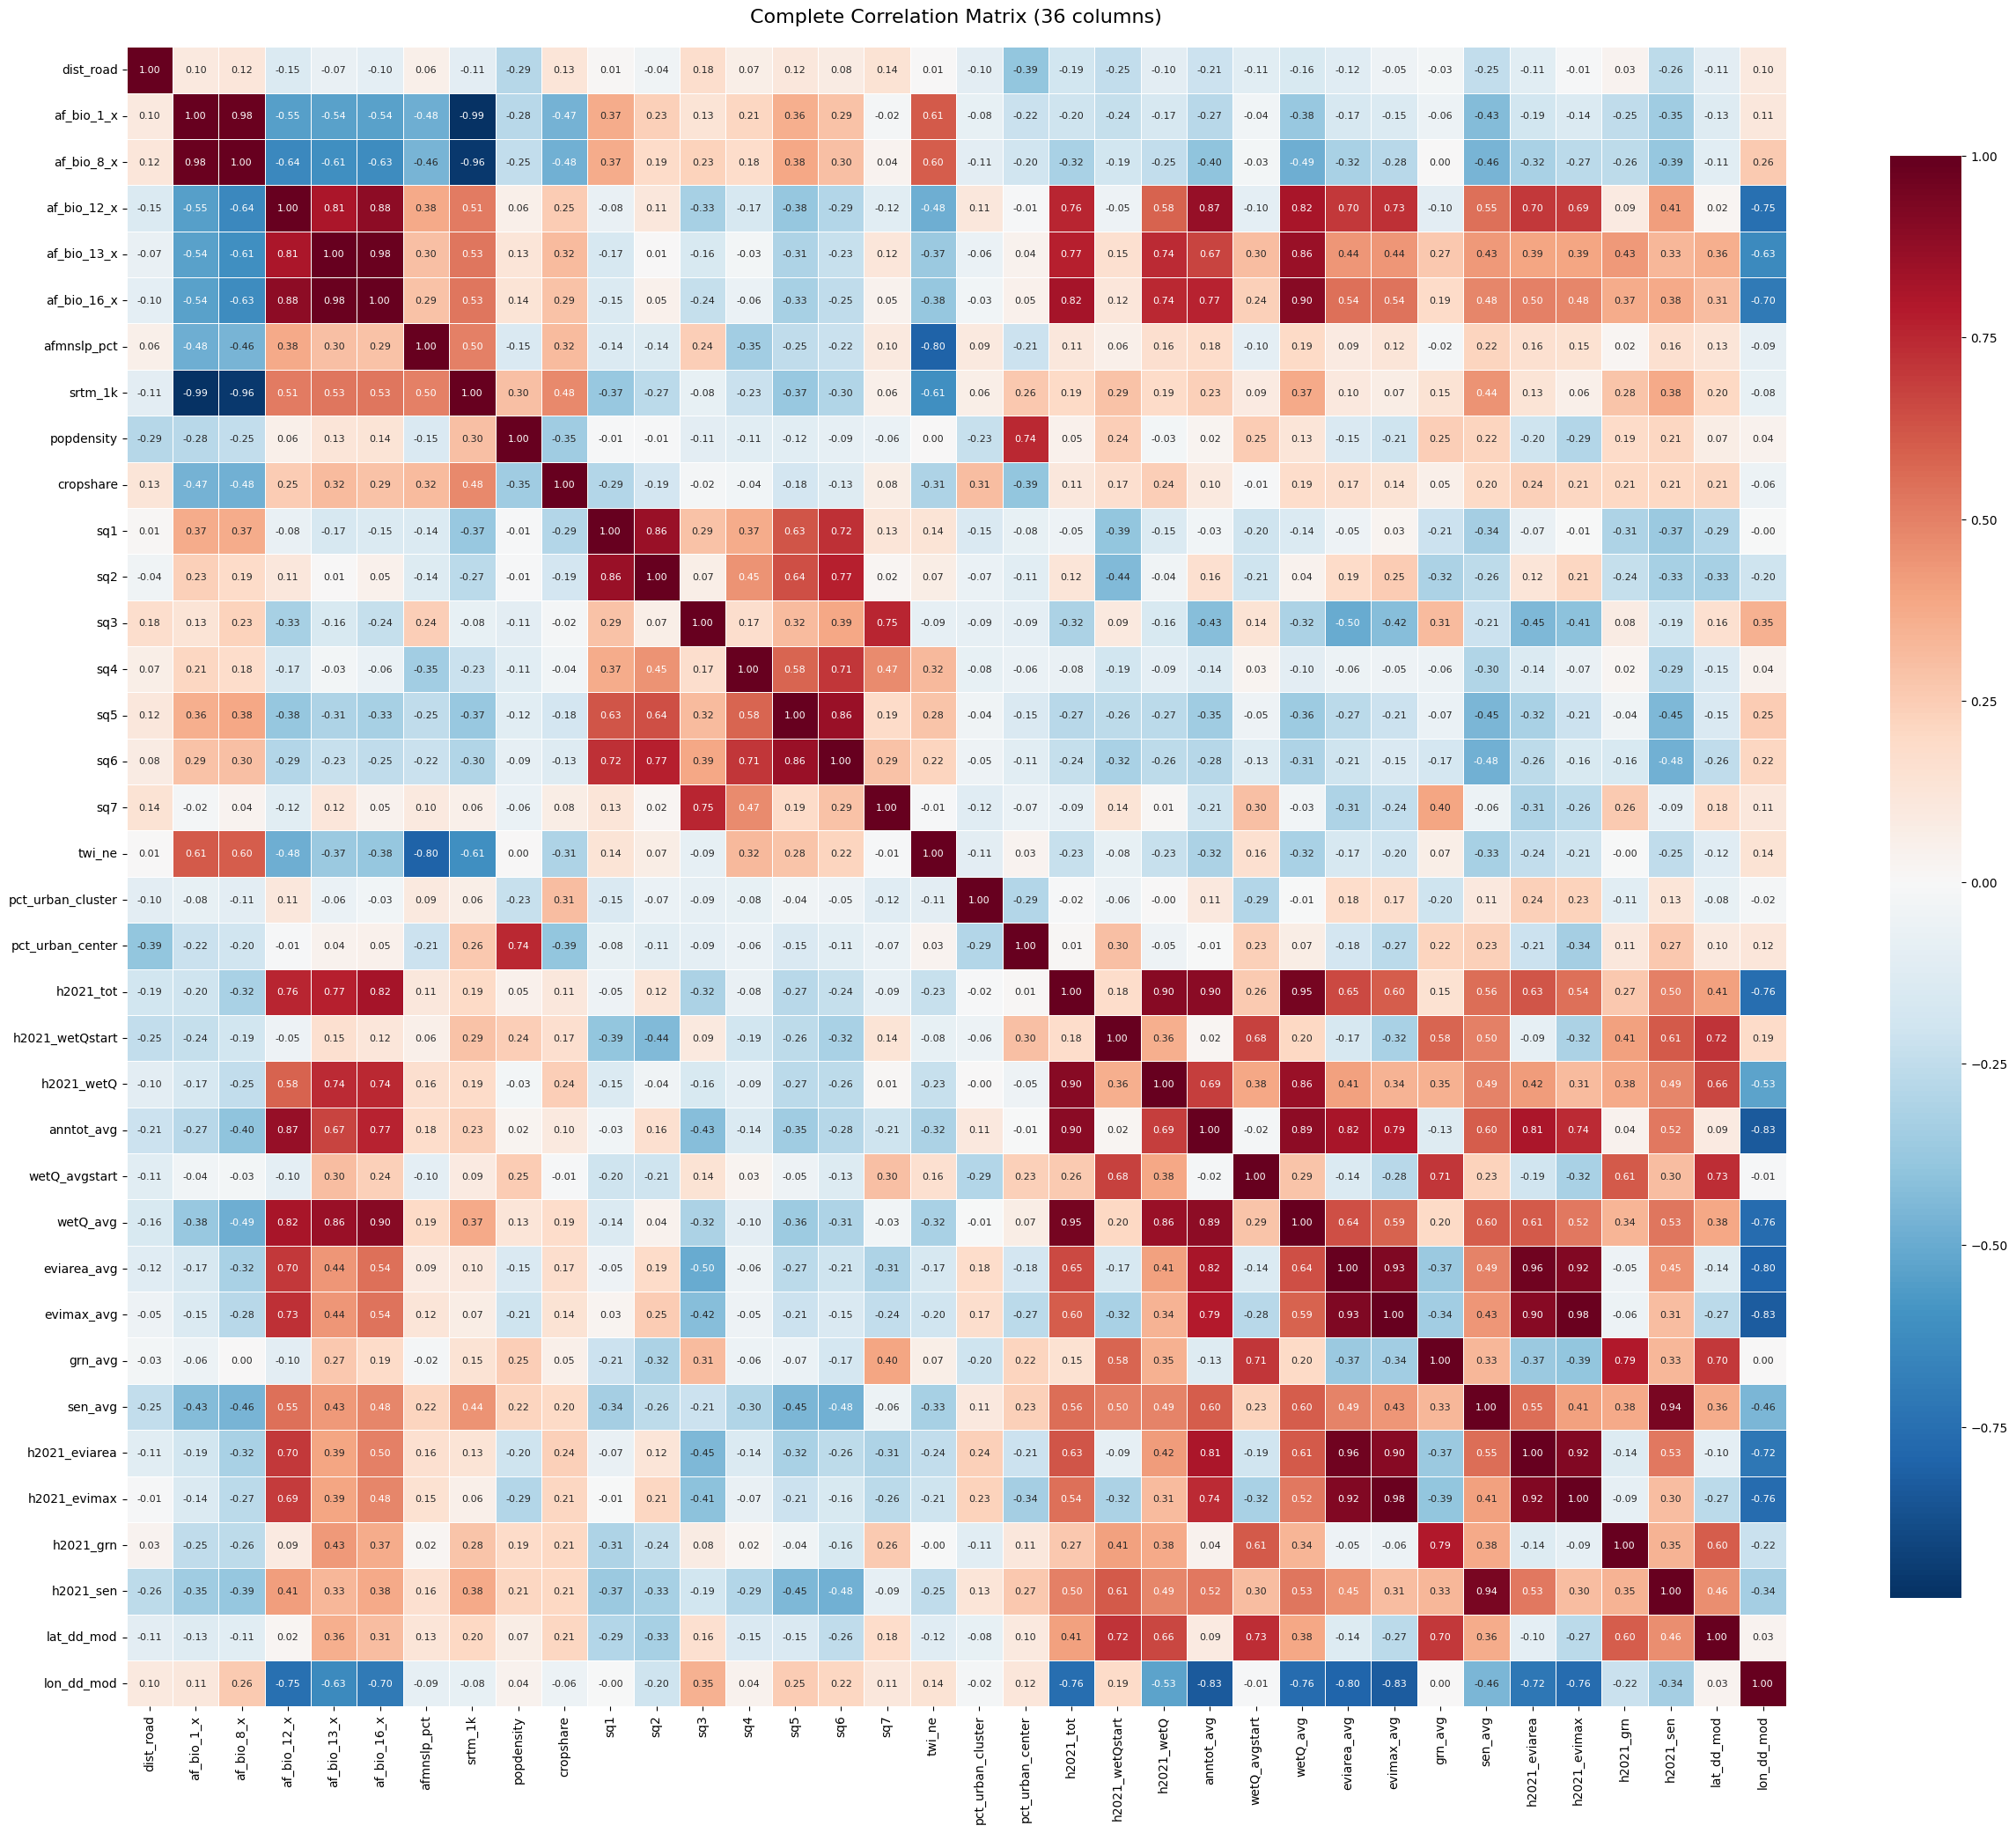


3. TARGET CORRELATION ANALYSIS
----------------------------------------

Top 10 features correlated with 'dist_road':
--------------------------------------------------
 1. pct_urban_center               :  -0.394 (negative)
 2. popdensity                     :  -0.285 (negative)
 3. h2021_sen                      :  -0.263 (negative)
 4. sen_avg                        :  -0.246 (negative)
 5. h2021_wetQstart                :  -0.246 (negative)
 6. anntot_avg                     :  -0.214 (negative)
 7. h2021_tot                      :  -0.186 (negative)
 8. sq3                            :   0.177 (positive)
 9. wetQ_avg                       :  -0.160 (negative)
10. af_bio_12_x                    :  -0.145 (negative)


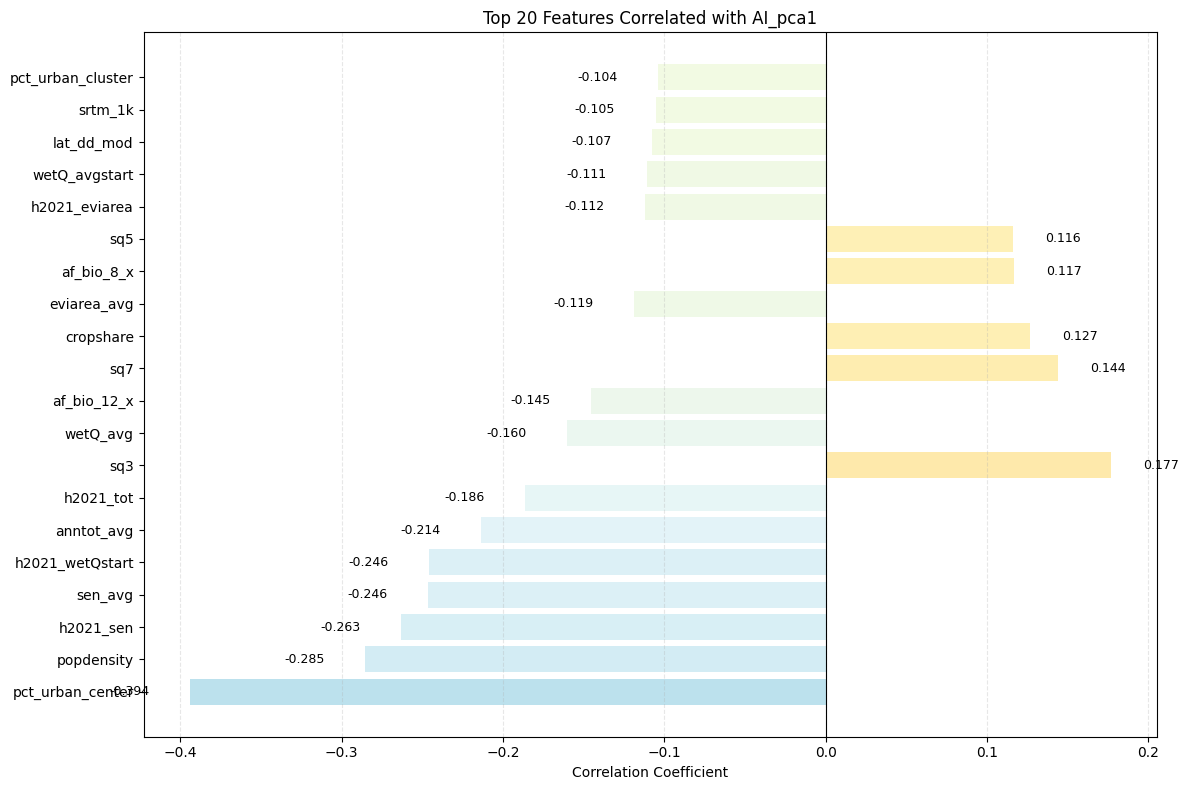


4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
----------------------------------------
Calculating VIF for 33 features...

VIF RESULTS SUMMARY:
------------------------------------------------------------
Feature                        VIF      Status      
------------------------------------------------------------
🔴 af_bio_16_x                    167.17 HIGH VIF    
🔴 af_bio_8_x                     165.72 HIGH VIF    
🔴 h2021_evimax                   161.51 HIGH VIF    
🔴 af_bio_1_x                     148.07 HIGH VIF    
🔴 h2021_eviarea                  125.05 HIGH VIF    
🔴 evimax_avg                     120.09 HIGH VIF    
🔴 srtm_1k                        110.31 HIGH VIF    
🔴 af_bio_13_x                     98.54 HIGH VIF    
🔴 eviarea_avg                     87.09 HIGH VIF    
🔴 h2021_tot                       71.67 HIGH VIF    
🔴 anntot_avg                      69.33 HIGH VIF    
🔴 wetQ_avg                        59.13 HIGH VIF    
🔴 h2021_wetQ                      40.14 HIGH VI

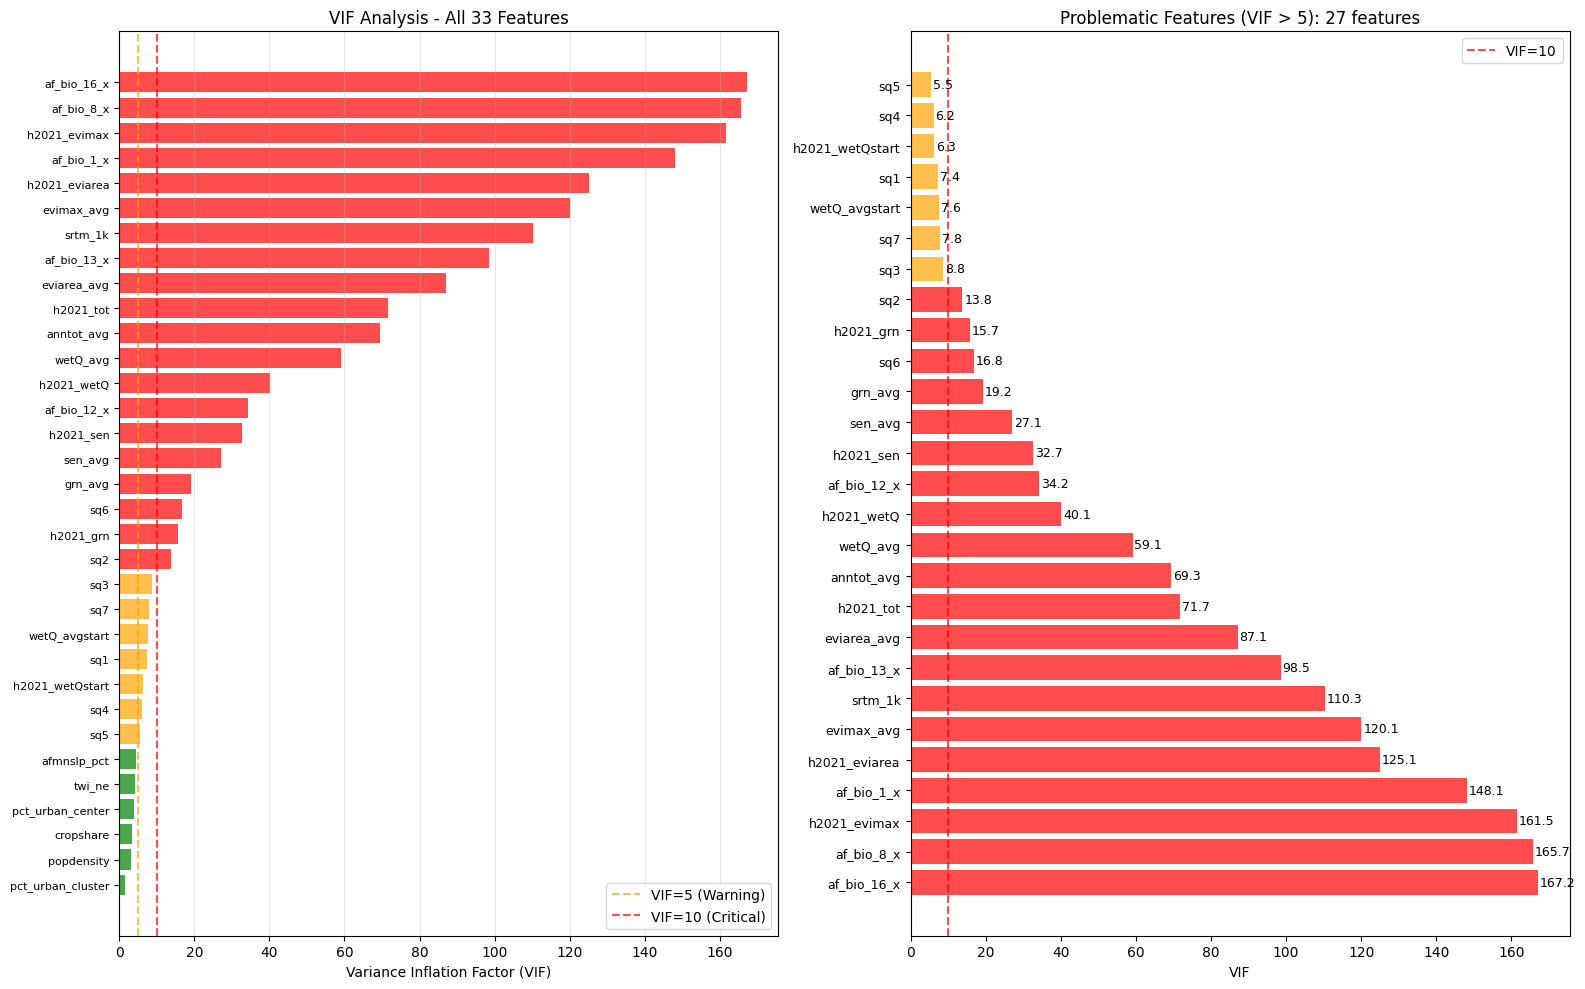


6. HIGHLY CORRELATED FEATURE PAIRS
----------------------------------------
Found 30 pairs with |correlation| > 0.8:
--------------------------------------------------------------------------------
Feature 1                      Feature 2                      Correlation 
--------------------------------------------------------------------------------
af_bio_1_x                     srtm_1k                              -0.985
evimax_avg                     h2021_evimax                          0.983
af_bio_13_x                    af_bio_16_x                           0.982
af_bio_1_x                     af_bio_8_x                            0.979
eviarea_avg                    h2021_eviarea                         0.963
af_bio_8_x                     srtm_1k                              -0.958
h2021_tot                      wetQ_avg                              0.947
sen_avg                        h2021_sen                             0.939
eviarea_avg                    evimax_avg    

In [44]:
# =============================================================================
# CORRELATION & VIF ANALYSIS - COMPLETE VERSION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print("\n" + "="*60)
print("COMPREHENSIVE CORRELATION AND VIF ANALYSIS")
print("="*60)

# =============================================================================
# 1. PREPARE DATA WITH ALL COLUMNS
# =============================================================================
print("\n1. PREPARING ALL DATA COLUMNS")
print("-"*40)

# Get ALL numerical columns from original dataframe
all_numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numerical columns in df: {len(all_numerical_cols)}")

# Create DataFrame with ALL numerical columns + target
full_data = df[all_numerical_cols].copy()

# Make sure is included (it's already in df from your preprocessing)
print(f"Including target column: 'dist_road'")

# Display column count
print(f"\nAnalyzing {len(full_data.columns)} columns total:")

# =============================================================================
# 2. COMPREHENSIVE CORRELATION HEATMAP WITH NUMBERS
# =============================================================================
print("\n2. CORRELATION HEATMAP (WITH VALUES)")
print("-"*40)

# Calculate correlation matrix
corr_matrix = full_data.corr()

# Determine figure size based on number of columns
n_cols = len(corr_matrix.columns)
fig_width = max(20, n_cols * 0.7)
fig_height = max(18, n_cols * 0.6)

plt.figure(figsize=(fig_width, fig_height))

# Create heatmap with numbers
sns.heatmap(corr_matrix,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=True,  # Show numbers
            annot_kws={'size': 8},  # Font size for numbers
            fmt='.2f',  # Format numbers to 2 decimal places
            xticklabels=True,
            yticklabels=True)

plt.title(f'Complete Correlation Matrix ({n_cols} columns)', fontsize=16, pad=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. TARGET-SPECIFIC CORRELATION ANALYSIS
# =============================================================================
print("\n3. TARGET CORRELATION ANALYSIS")
print("-"*40)

# Find correlations with 'dist_road'
if 'dist_road' in corr_matrix.columns:
    target_corrs = corr_matrix['dist_road'].drop('dist_road').sort_values(key=abs, ascending=False)

    print(f"\nTop 10 features correlated with 'dist_road':")
    print("-"*50)
    for i, (feat, corr) in enumerate(target_corrs.head(10).items(), 1):
        direction = "positive" if corr > 0 else "negative"
        print(f"{i:2}. {feat:30} : {corr:7.3f} ({direction})")

    # Plot top correlations
    plt.figure(figsize=(12, 8))
    top_20 = target_corrs.head(20)

    # Create color gradient
    colors = plt.cm.RdYlBu_r((top_20.values + 1) / 2)

    bars = plt.barh(range(len(top_20)), top_20.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top_20)), top_20.index)
    plt.axvline(x=0, color='black', linewidth=0.8)
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 20 Features Correlated with AI_pca1')
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars, top_20.values)):
        x_pos = val + (0.02 if val >= 0 else -0.05)
        plt.text(x_pos, i, f'{val:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
# =============================================================================
print("\n4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES")
print("-"*40)

# Remove target column for VIF calculation (if present)
# Remove target column + spatial columns for VIF calculation
exclude_cols = ['dist_road', 'lat_dd_mod', 'lon_dd_mod']  # keep lat/lon for mapping
features_for_vif = [col for col in full_data.columns if col not in exclude_cols]

X_for_vif = full_data[features_for_vif].copy()

print(f"Calculating VIF for {len(X_for_vif.columns)} features...")

# Calculate VIF
def calculate_vif_safe(X_df, max_features=50):
    """Calculate VIF safely handling large datasets"""
    if len(X_df.columns) > max_features:
        print(f"  Note: Calculating VIF for {len(X_df.columns)} features may take time...")

    X_const = add_constant(X_df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns

    vif_values = []
    for i in range(X_const.shape[1]):
        try:
            vif = variance_inflation_factor(X_const.values, i)
            vif_values.append(vif)
        except:
            vif_values.append(np.nan)

    vif_data["VIF"] = vif_values
    vif_data = vif_data[vif_data['feature'] != 'const']
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif_safe(X_for_vif)

print(f"\nVIF RESULTS SUMMARY:")
print("-"*60)
print(f"{'Feature':30} {'VIF':8} {'Status':12}")
print("-"*60)

# Display results with categorization
for _, row in vif_results.iterrows():
    vif_val = row['VIF']
    if pd.isna(vif_val):
        status = "ERROR"
        symbol = "?"
    elif vif_val > 10:
        status = "HIGH VIF"
        symbol = "🔴"
    elif vif_val > 5:
        status = "MODERATE"
        symbol = "🟡"
    else:
        status = "OK"
        symbol = "🟢"

    print(f"{symbol} {row['feature']:28} {vif_val:8.2f} {status:12}")

# =============================================================================
# 5. VIF VISUALIZATION
# =============================================================================
print("\n5. VIF VISUALIZATION")
print("-"*40)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plot 1: All VIF values
vif_sorted = vif_results.sort_values('VIF')
axes[0].barh(range(len(vif_sorted)), vif_sorted['VIF'],
             color=['red' if v > 10 else 'orange' if v > 5 else 'green'
                    for v in vif_sorted['VIF']],
             alpha=0.7)
axes[0].set_yticks(range(len(vif_sorted)))
axes[0].set_yticklabels(vif_sorted['feature'], fontsize=8)
axes[0].axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='VIF=5 (Warning)')
axes[0].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10 (Critical)')
axes[0].set_xlabel('Variance Inflation Factor (VIF)')
axes[0].set_title(f'VIF Analysis - All {len(vif_sorted)} Features')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Problematic features only
problematic = vif_results[vif_results['VIF'] > 5]
if len(problematic) > 0:
    axes[1].barh(range(len(problematic)), problematic['VIF'],
                 color=['red' if v > 10 else 'orange' for v in problematic['VIF']],
                 alpha=0.7)
    axes[1].set_yticks(range(len(problematic)))
    axes[1].set_yticklabels(problematic['feature'], fontsize=9)
    axes[1].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10')
    axes[1].set_xlabel('VIF')
    axes[1].set_title(f'Problematic Features (VIF > 5): {len(problematic)} features')
    axes[1].legend()

    # Add VIF values on bars
    for i, (_, row) in enumerate(problematic.iterrows()):
        axes[1].text(row['VIF'] + 0.5, i, f'{row["VIF"]:.1f}',
                    va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No VIF issues!\nAll features have VIF < 5',
                ha='center', va='center', transform=axes[1].transAxes,
                fontsize=14, color='green')
    axes[1].set_title('No Multicollinearity Issues')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
print("\n6. HIGHLY CORRELATED FEATURE PAIRS")
print("-"*40)

threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_val))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} pairs with |correlation| > {threshold}:")
    print("-"*80)
    print(f"{'Feature 1':30} {'Feature 2':30} {'Correlation':12}")
    print("-"*80)

    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1:30} {feat2:30} {corr:12.3f}")
else:
    print(f"No feature pairs found with |correlation| > {threshold}")

# =============================================================================
# 7. COMPREHENSIVE SUMMARY
# =============================================================================
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

# Summary statistics
high_vif = vif_results[vif_results['VIF'] > 10]
moderate_vif = vif_results[(vif_results['VIF'] > 5) & (vif_results['VIF'] <= 10)]

print(f"\n📊 SUMMARY STATISTICS:")
print(f"  • Total columns analyzed: {len(full_data.columns)}")
print(f"  • Features with HIGH VIF (>10): {len(high_vif)}")
print(f"  • Features with MODERATE VIF (5-10): {len(moderate_vif)}")
print(f"  • Highly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
print(f"  • Maximum VIF: {vif_results['VIF'].max():.2f}")
print(f"  • Average VIF: {vif_results['VIF'].mean():.2f}")

# Top correlations with target
if 'AI_pca1' in corr_matrix.columns:
    top_target_corr = target_corrs.head(3)
    print(f"\n🎯 TOP FEATURES FOR TARGET PREDICTION:")
    for feat, corr in top_target_corr.items():
        vif_val = vif_results[vif_results['feature'] == feat]['VIF'].values[0] if feat in vif_results['feature'].values else np.nan
        print(f"  • {feat}: correlation = {corr:.3f}, VIF = {vif_val:.2f}")

# Recommendations
print(f"\n⚠️  RECOMMENDATIONS:")
if len(high_vif) > 0:
    print(f"  1. Consider removing features with VIF > 10:")
    for _, row in high_vif.head(5).iterrows():
        print(f"     - {row['feature']} (VIF = {row['VIF']:.1f})")
if len(high_corr_pairs) > 0:
    print(f"  2. Check these highly correlated pairs for redundancy")
if len(high_vif) == 0 and len(high_corr_pairs) == 0:
    print("  ✓ No major multicollinearity issues detected!")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

# Store results for later use
analysis_results = {
    'correlation_matrix': corr_matrix,
    'vif_results': vif_results,
    'high_correlation_pairs': high_corr_pairs,
    'target_correlations': target_corrs if 'AI_pca1' in corr_matrix.columns else None
}

print("\nResults stored in 'analysis_results' dictionary")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 51 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   dist_road                                   4890 non-null   float64 
 1   af_bio_1_x                                  4890 non-null   int64   
 2   af_bio_8_x                                  4890 non-null   int64   
 3   af_bio_12_x                                 4890 non-null   int64   
 4   af_bio_13_x                                 4890 non-null   int64   
 5   af_bio_16_x                                 4890 non-null   int64   
 6   afmnslp_pct                                 4890 non-null   int64   
 7   srtm_1k                                     4890 non-null   int64   
 8   popdensity                                  4890 non-null   int64   
 9   cropshare                                   4890 non-null   int64   
 10  

In [46]:
to_drop = [
    'h2021_evimax', 'h2021_eviarea', 'h2021_tot', 'h2021_wetQ',
    'af_bio_8_x', 'af_bio_13_x', 'af_bio_16_x',
    'sq2', 'sq6','srtm_1k',
    'h2021_sen',
    'evimax_avg',
    'wetQ_avg',       # or anntot_avg — pick one
    'twi_ne','anntot_avg','grn_avg'
]

df_reduced = df.drop(columns=to_drop)
df=df_reduced.copy()

In [47]:
exclude_cols = [
    'road_access',
    'lat_dd_mod',
    'dist_road',
    'lon_dd_mod',
    'household_id'
]

X = df.drop(columns=exclude_cols, errors='ignore')
y = df['road_access']

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [49]:
print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))

Train distribution:
road_access
Very Good    0.571830
Poor         0.219836
Moderate     0.110941
Good         0.097393
Name: proportion, dtype: float64

Test distribution:
road_access
Very Good    0.571575
Poor         0.219836
Moderate     0.111452
Good         0.097137
Name: proportion, dtype: float64



Training LogisticRegression...
LogisticRegression Accuracy: 0.6810

              precision    recall  f1-score   support

        Good     0.3027    0.5895    0.4000        95
    Moderate     0.3797    0.5505    0.4494       109
        Poor     0.6413    0.6651    0.6530       215
   Very Good     0.9879    0.7281    0.8383       559

    accuracy                         0.6810       978
   macro avg     0.5779    0.6333    0.5852       978
weighted avg     0.7773    0.6810    0.7116       978

------------------------------------------------------------

Training RandomForest...
RandomForest Accuracy: 0.9959

              precision    recall  f1-score   support

        Good     0.9895    0.9895    0.9895        95
    Moderate     0.9909    1.0000    0.9954       109
        Poor     0.9953    0.9907    0.9930       215
   Very Good     0.9982    0.9982    0.9982       559

    accuracy                         0.9959       978
   macro avg     0.9935    0.9946    0.9940       97

,model,accuracy
1,RandomForest,0.995910
2,XGBoost,0.995910
0,LogisticRegression,0.680982



Best classifier: RandomForest

Confusion Matrix (Values):


,Good,Moderate,Poor,Very Good
Good,94,0,0,1
Moderate,0,109,0,0
Poor,1,1,213,0
Very Good,0,0,1,558


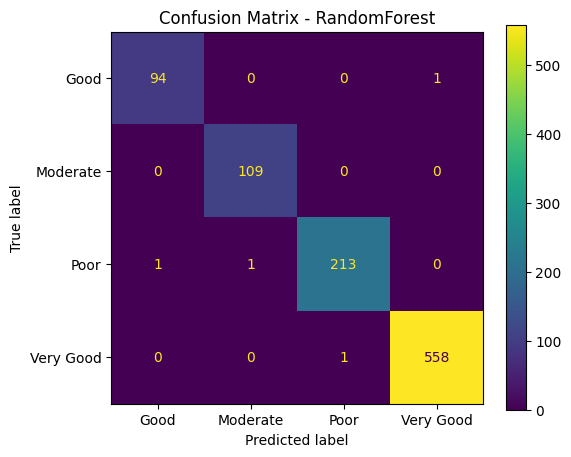

In [50]:
# ==========================================================
# CLASSIFICATION: TRAIN MODELS + METRICS + CONFUSION MATRIX
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Optional model imports
try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

# ----------------------------------------------------------
# SCALE FEATURES (important for Logistic Regression)
# ----------------------------------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------------
# Encode labels
# ----------------------------------------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ----------------------------------------------------------
# Define models
# ----------------------------------------------------------
models_clf = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced'
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

if xgb_available:
    models_clf["XGBoost"] = XGBClassifier(
        n_estimators=200,
        eval_metric='mlogloss',
        random_state=42,
        tree_method="hist"   # faster & stable
    )

# ----------------------------------------------------------
# Train Models
# ----------------------------------------------------------
fitted_clf = {}
results_clf = []

for name, model in models_clf.items():
    print(f"\nTraining {name}...")

    # Logistic Regression needs scaled data
    if name == "LogisticRegression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, preds)

    elif name == "XGBoost":
        model.fit(X_train, y_train_enc)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test_enc, preds)

    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)

    print(f"{name} Accuracy: {acc:.4f}\n")

    # classification report
    if name == "XGBoost":
        print(classification_report(y_test_enc, preds,
                                    target_names=le.classes_,
                                    digits=4))
    else:
        print(classification_report(y_test, preds,
                                    target_names=le.classes_,
                                    digits=4))

    results_clf.append((name, acc))
    fitted_clf[name] = model
    print("-"*60)

# ----------------------------------------------------------
# Summary table
# ----------------------------------------------------------
resclf_df = pd.DataFrame(results_clf,
                         columns=["model", "accuracy"]
                         ).sort_values("accuracy", ascending=False)

from IPython.display import display
display(resclf_df)

# ----------------------------------------------------------
# Best Model
# ----------------------------------------------------------
best_clf_name = resclf_df.iloc[0]["model"]
best_clf = fitted_clf[best_clf_name]

print("\nBest classifier:", best_clf_name)

# ----------------------------------------------------------
# Predictions for confusion matrix
# ----------------------------------------------------------
if best_clf_name == "LogisticRegression":
    y_pred_best = best_clf.predict(X_test_scaled)
    y_true = y_test

elif best_clf_name == "XGBoost":
    y_pred_best = best_clf.predict(X_test)
    y_true = y_test_enc

else:
    y_pred_best = best_clf.predict(X_test)
    y_true = y_test

# ----------------------------------------------------------
# CONFUSION MATRIX (NUMERICAL)
# ----------------------------------------------------------
cm = confusion_matrix(y_true, y_pred_best)

cm_df = pd.DataFrame(cm,
                     index=le.classes_,
                     columns=le.classes_)

print("\nConfusion Matrix (Values):")
display(cm_df)

# ----------------------------------------------------------
# CONFUSION MATRIX (PLOT)
# ----------------------------------------------------------
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, values_format='d')
plt.title(f"Confusion Matrix - {best_clf_name}")
plt.show()


OVERFITTING CHECK + FEATURE IMPORTANCE + SHAP

Train vs Test Accuracy Gap:
LogisticRegression  Train: 0.5695   Test: 0.5695   Gap: 0.0000
RandomForest        Train: 1.0000   Test: 0.9959   Gap: 0.0041
XGBoost             Train: 1.0000   Test: 0.9959   Gap: 0.0041

→ Large gap (>0.05–0.10) suggests overfitting

5-fold Cross-Validation Accuracy:
LogisticRegression  CV mean: 0.6587 ± 0.0232
RandomForest        CV mean: 0.9959 ± 0.0019
XGBoost             CV mean: 0.9954 ± 0.0026

Feature Importance (Top 12):
          Feature  Importance
       popdensity     0.17515
 pct_urban_center     0.10048
        cropshare     0.08155
pct_urban_cluster     0.07107
      af_bio_12_x     0.06755
      afmnslp_pct     0.06167
       af_bio_1_x     0.06105
      eviarea_avg     0.04785
          sen_avg     0.04323
        h2021_grn     0.04185
  h2021_wetQstart     0.03475
    wetQ_avgstart     0.03407


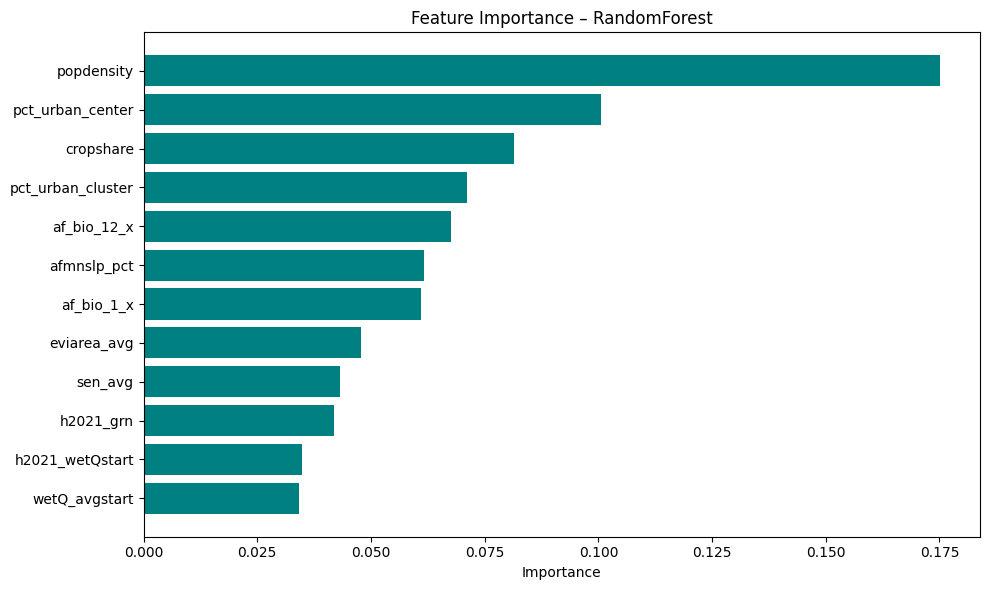


Generating SHAP summary plot...


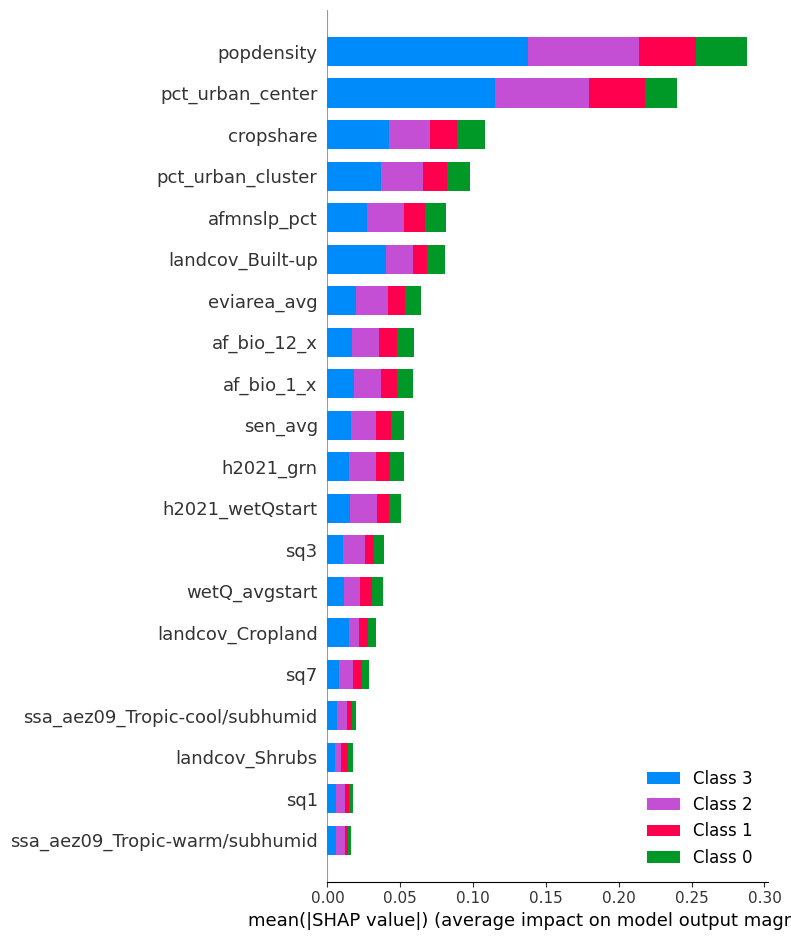

In [51]:
# =============================================================================
# OVERFITTING CHECK + FEATURE IMPORTANCE + SHAP
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")  # suppress convergence warnings, etc.

print("\n" + "="*50)
print("OVERFITTING CHECK + FEATURE IMPORTANCE + SHAP")
print("="*50)

# ===========================
# 1. Train vs Test Accuracy Gap
# ===========================
print("\nTrain vs Test Accuracy Gap:")

for name, model in fitted_clf.items():
    if name == "XGBoost":
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train_enc, train_pred)
        test_acc = accuracy_score(y_test_enc, test_pred)
    else:
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

    gap = train_acc - test_acc
    print(f"{name:18}  Train: {train_acc:.4f}   Test: {test_acc:.4f}   Gap: {gap:.4f}")

print("\n→ Large gap (>0.05–0.10) suggests overfitting")

# ===========================
# 2. 5-Fold Cross-Validation Accuracy
# ===========================
print("\n5-fold Cross-Validation Accuracy:")
for name, model in fitted_clf.items():
    if name == "XGBoost":
        scores = cross_val_score(model, X_train, y_train_enc, cv=5, scoring='accuracy', n_jobs=-1)
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"{name:18}  CV mean: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# ===========================
# 3. Feature Importance (Top 12)
# ===========================
print("\nFeature Importance (Top 12):")
best_model = fitted_clf[best_clf_name]

if best_clf_name in ["RandomForest", "XGBoost"]:
    imp = best_model.feature_importances_
    idx = np.argsort(imp)[::-1]
    top_features = pd.DataFrame({
        'Feature': X.columns[idx][:12],
        'Importance': imp[idx][:12]
    })
    print(top_features.round(5).to_string(index=False))

    # Bar plot
    plt.figure(figsize=(10,6))
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')
    plt.title(f"Feature Importance – {best_clf_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # ===========================
    # 4. SHAP Summary Plot
    # ===========================
    print("\nGenerating SHAP summary plot...")
    # Create SHAP explainer
    if best_clf_name == "RandomForest":
        explainer = shap.TreeExplainer(best_model)
    else:  # XGBoost
        explainer = shap.TreeExplainer(best_model, feature_perturbation="tree_path_dependent")

    # Compute SHAP values on a sample to speed up if dataset is large
    sample_X = X_train.sample(n=min(1000, X_train.shape[0]), random_state=42)
    shap_values = explainer.shap_values(sample_X)

    # SHAP summary plot
    shap.summary_plot(shap_values, sample_X, plot_type="bar", show=True)

else:
    print("→ LogisticRegression has no built-in feature importance.")
    print("   Use permutation importance or SHAP KernelExplainer for linear models.")

In [52]:
# =============================================================================
# SPATIAL MAP FOR ROAD ACCESS CLASSIFICATION
# =============================================================================

import folium
from folium.plugins import MarkerCluster, HeatMap
import geopandas as gpd

# 1. Prepare map DataFrame (from X_test / predictions)
map_df = X_test.copy()
map_df['true_class'] = y_test
map_df['pred_class'] = y_pred_best  # from best classifier
# Add lat/lon (ensure these columns exist in original df)
map_df['lat'] = df.loc[X_test.index, 'lat_dd_mod']
map_df['lon'] = df.loc[X_test.index, 'lon_dd_mod']

# Drop rows with missing coordinates
map_df = map_df.dropna(subset=['lat','lon'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    map_df,
    geometry=gpd.points_from_xy(map_df.lon, map_df.lat),
    crs="EPSG:4326"
)

# 2. Base map
m = folium.Map(location=[gdf.lat.mean(), gdf.lon.mean()], zoom_start=6, tiles='cartodbpositron')

# 3. Marker cluster for households
marker_layer = MarkerCluster(name="Households").add_to(m)

# Color map for predicted classes
color_map = {
    'Good':'green',
    'Moderate':'orange',
    'Poor':'red',
    'Very Good':'blue'
}

# Add markers
for _, row in gdf.iterrows():
    folium.Marker(
        [row.lat, row.lon],
        popup=f"""
        <b>Road Access Prediction:</b> {row.pred_class}<br>
        <b>Actual:</b> {row.true_class}
        """,
        icon=folium.Icon(color=color_map[row.pred_class])
    ).add_to(marker_layer)

# 4. Heatmap for Poor access areas
poor_points = gdf[gdf.pred_class=='Poor'][['lat','lon']].values.tolist()
if poor_points:
    HeatMap(poor_points, radius=12, name="Poor Road Access").add_to(m)

# 5. Legend
legend_html = """
<div style="
position: fixed;
bottom: 40px;
left: 40px;
width: 200px;
height: 180px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding: 10px;
">
<b>Road Access Classes</b><br>
<i style="color:blue">●</i> Very Good<br>
<i style="color:green">●</i> Good<br>
<i style="color:orange">●</i> Moderate<br>
<i style="color:red">●</i> Poor<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# 6. Layer control
folium.LayerControl().add_to(m)

# 7. Show map
m
# Optional: save map
# m.save("road_access_map.html")